In [1]:
import glob

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm


In [2]:
def purge_conf(conf_dict):
    keep_keys = ['raftTypeStr', 'nodes']
    return {k:v for k,v in conf_dict.items() if k in keep_keys}

In [37]:
def parse_line_election(message, timestamp, curr_dict, node_name, num_nodes):
    append = False
        # Start of election: "Change behavior from 'LEADER' to 'SLEEP'"
    if "Change behavior from 'LEADER' to 'SLEEP'" in message:
        curr_dict['election_start'] = timestamp
        curr_dict['messages'] = [message]
    elif "Change behavior from 'CANDIDATE' to 'LEADER'" in message and curr_dict.get('election_start'):
        curr_dict['election_end'] = timestamp
        curr_dict['messages'] = curr_dict['messages'] + [message]
        append = True
    elif "Received message" in message:
        if curr_dict.get('election_start'):
            curr_dict['messages'] = curr_dict.get('messages', []) + [message]

    return curr_dict, append

def parse_line_appenddata(message, timestamp, curr_dict, node_name, num_nodes):
    append = False
    if "SEND APR" in message:
        if not curr_dict.get('appenddata_start'):
            curr_dict['appenddata_start'] = timestamp
    if "FOLLOWER WRITING DATA" in message:
        curr_dict['appenddata_end'] = timestamp
        # (data = Map(x -> 5, y -> 4, z -> 3, q -> 2))
        data_map_str = message.split(', (')[1][11:-2]
        entries = data_map_str.split(', ')

        curr_node_entry_set = curr_dict['written_data'].get(node_name, set())
        curr_node_entry_set.update(entries)
        curr_dict['written_data'][node_name] = curr_node_entry_set

        # if all followers have written all data set append to True
        num_appended = 0
        for data in curr_dict['written_data'].values():
            if len(data) == 4:
                num_appended += 1
        if num_appended + 1 == (num_nodes // 2) + 1:
            # print(f"Finish, nodes written = {num_appended}: {message = }")
            curr_dict['appenddata_majority'] = timestamp
    if "[VERIFY APPEND DATA], Consistent" in message:
        curr_dict.pop('written_data')
        append = True

    return curr_dict, append

def load_logfile(file, exp_type='election') -> list:
    with open(file, 'r') as f:
        logs = f.readlines()

    log_start_idx = -1
    # find start of actual logs and parse config:
    conf = {}
    for i, log in enumerate(logs):
        if 'Starting Main with Config' in log:
            log_start_idx = i
            conf = {x.split('=')[0]: x.split('=')[1] for x in log[:-2].split("Config:")[-1].split(',')}
            break

    logs = logs[log_start_idx:]
    conf = purge_conf(conf)
    conf['file'] = file
    conf['nodes'] = int(conf['nodes'])

    if exp_type == 'appenddata':
        conf['written_data'] = {}
        parse_line_func = parse_line_appenddata
    else:
        parse_line_func = parse_line_election

    results = []
    curr_dict = conf.copy()
    for log in logs:
        # split message, indices: 0=timestamp, 1=loglevel, 2=akka actor string, 3=message
        timestamp, _, node_name, message = log.split('\t')
        timestamp = timestamp[1:-1]
        node_name = node_name.split('/')[-1][:-1]
        curr_dict, append = parse_line_func(message, timestamp, curr_dict, node_name, conf['nodes'])
        if append:
            # curr_dict.pop('written_data', None)
            results.append(curr_dict)
            curr_dict = conf.copy()

    return results

In [33]:
load_logfile('resources/output/append_data_1/run1_raftType=BRaft_crashIntervalHeartbeats=10000_nodes=21.log', 'appenddata')

[{'raftTypeStr': 'BRaft',
  'nodes': 21,
  'file': 'resources/output/append_data_1/run1_raftType=BRaft_crashIntervalHeartbeats=10000_nodes=21.log',
  'written_data': {'BraftNodeActor-3': {'q -> 2',
    'x -> 5',
    'y -> 4',
    'z -> 3'},
   'BraftNodeActor-10': {'q -> 2', 'x -> 5', 'y -> 4', 'z -> 3'},
   'BraftNodeActor-19': {'q -> 2', 'x -> 5', 'y -> 4', 'z -> 3'},
   'BraftNodeActor-20': {'q -> 2', 'x -> 5', 'y -> 4', 'z -> 3'},
   'BraftNodeActor-15': {'q -> 2', 'x -> 5', 'y -> 4', 'z -> 3'},
   'BraftNodeActor-18': {'q -> 2', 'x -> 5', 'y -> 4', 'z -> 3'},
   'BraftNodeActor-6': {'q -> 2', 'x -> 5', 'y -> 4', 'z -> 3'},
   'BraftNodeActor-9': {'q -> 2', 'x -> 5', 'y -> 4', 'z -> 3'},
   'BraftNodeActor-16': {'q -> 2', 'x -> 5', 'y -> 4', 'z -> 3'},
   'BraftNodeActor-4': {'q -> 2', 'x -> 5', 'y -> 4', 'z -> 3'},
   'BraftNodeActor-5': {'q -> 2', 'x -> 5', 'y -> 4', 'z -> 3'},
   'BraftNodeActor-12': {'q -> 2', 'x -> 5', 'y -> 4', 'z -> 3'},
   'BraftNodeActor-7': {'q -> 2', 'x 

In [64]:
# appenddata_results = []
# for file in glob.glob('resources/output/append_data*/*.log'):
#     appenddata_results.extend(load_logfile(file, 'appenddata'))
#
# append_df = pd.json_normalize(appenddata_results)
# append_df['start'] = pd.to_datetime(append_df.appenddata_start)
# append_df['end'] = pd.to_datetime(append_df.appenddata_end)
# append_df['majority'] = pd.to_datetime(append_df.appenddata_majority)
#
# append_df['duration_ms'] = (append_df.end - append_df.start).astype(np.int64) / int(1e6)
# append_df['duration_majority_ms'] = (append_df.majority - append_df.start).astype(np.int64) / int(1e6)
# append_df['duration_majority_s'] = append_df.duration_majority_ms / 1000
# append_df['duration_s'] = append_df.duration_ms / 1000
# append_df.to_json('appenddata_results.json.gz',  compression='gzip')
# append_df

append_df = pd.read_json('appenddata_results.json.gz', compression='gzip')

C:\Users\ptema\AppData\Local\Temp\ipykernel_15576\3542859334.py:10: FutureWarning: casting timedelta64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  append_df['duration_ms'] = (append_df.end - append_df.start).astype(np.int64) / int(1e6)
C:\Users\ptema\AppData\Local\Temp\ipykernel_15576\3542859334.py:11: FutureWarning: casting timedelta64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  append_df['duration_majority_ms'] = (append_df.majority - append_df.start).astype(np.int64) / int(1e6)


,raftTypeStr,nodes,file,appenddata_start,appenddata_end,appenddata_majority,start,end,majority,duration_ms,duration_majority_ms,duration_majority_s,duration_s
0,BRaft,12,resources/output\append_data_1\run10_raftType=...,"2022-04-13 22:17:24,913","2022-04-13 22:17:30,267","2022-04-13 22:17:30,210",2022-04-13 22:17:24.913,2022-04-13 22:17:30.267,2022-04-13 22:17:30.210,5354.0,5297.0,5.297,5.354
1,BRaft,16,resources/output\append_data_1\run10_raftType=...,"2022-04-13 22:22:43,684","2022-04-13 22:22:51,915","2022-04-13 22:22:50,916",2022-04-13 22:22:43.684,2022-04-13 22:22:51.915,2022-04-13 22:22:50.916,8231.0,7232.0,7.232,8.231
2,BRaft,18,resources/output\append_data_1\run10_raftType=...,"2022-04-13 22:23:03,264","2022-04-13 22:23:13,604","2022-04-13 22:23:12,794",2022-04-13 22:23:03.264,2022-04-13 22:23:13.604,2022-04-13 22:23:12.794,10340.0,9530.0,9.530,10.340
3,BRaft,21,resources/output\append_data_1\run10_raftType=...,"2022-04-13 22:23:26,520","2022-04-13 22:23:39,048","2022-04-13 22:23:38,150",2022-04-13 22:23:26.520,2022-04-13 22:23:39.048,2022-04-13 22:23:38.150,12528.0,11630.0,11.630,12.528
4,BRaft,3,resources/output\append_data_1\run10_raftType=...,"2022-04-13 22:16:18,810","2022-04-13 22:16:20,527","2022-04-13 22:16:20,481",2022-04-13 22:16:18.810,2022-04-13 22:16:20.527,2022-04-13 22:16:20.481,1717.0,1671.0,1.671,1.717
...,...,...,...,...,...,...,...,...,...,...,...,...,...
491,Raft,21,resources/output\append_data_2\run4_raftType=R...,"2022-04-14 08:33:48,784","2022-04-14 08:33:50,935","2022-04-14 08:33:48,898",2022-04-14 08:33:48.784,2022-04-14 08:33:50.935,2022-04-14 08:33:48.898,2151.0,114.0,0.114,2.151
492,Raft,3,resources/output\append_data_2\run4_raftType=R...,"2022-04-14 08:31:57,141","2022-04-14 08:31:59,787","2022-04-14 08:31:59,787",2022-04-14 08:31:57.141,2022-04-14 08:31:59.787,2022-04-14 08:31:59.787,2646.0,2646.0,2.646,2.646
493,Raft,5,resources/output\append_data_2\run4_raftType=R...,"2022-04-14 08:32:11,079","2022-04-14 08:32:11,941","2022-04-14 08:32:11,940",2022-04-14 08:32:11.079,2022-04-14 08:32:11.941,2022-04-14 08:32:11.940,862.0,861.0,0.861,0.862
494,Raft,7,resources/output\append_data_2\run4_raftType=R...,"2022-04-14 08:32:25,042","2022-04-14 08:32:25,556","2022-04-14 08:32:25,555",2022-04-14 08:32:25.042,2022-04-14 08:32:25.556,2022-04-14 08:32:25.555,514.0,513.0,0.513,0.514


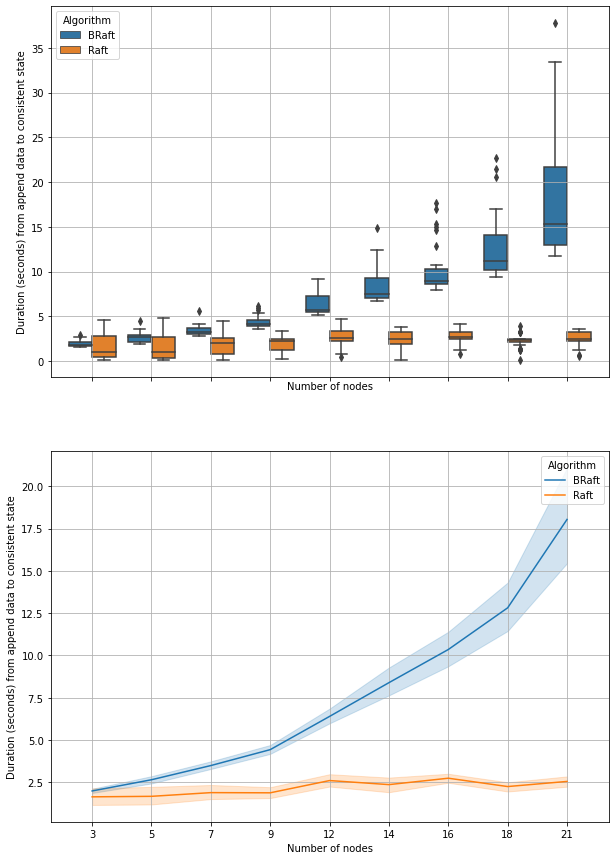

In [51]:
fig, axs = plt.subplots(2, 1, sharex='col', figsize=(10, 15))
axs = axs.flatten()
plot_box(append_df, ax=axs[0], y='duration_s', logy=False)
plot_line(append_df, ax=axs[1], y='duration_s', logy=False)

for ax in axs:
    ax.set_xlabel("Number of nodes")
    ax.set_ylabel("Duration (seconds) from append data to consistent state")
    ax.legend(title='Algorithm')

# fig.savefig('appenddata_duration.png', dpi=250)

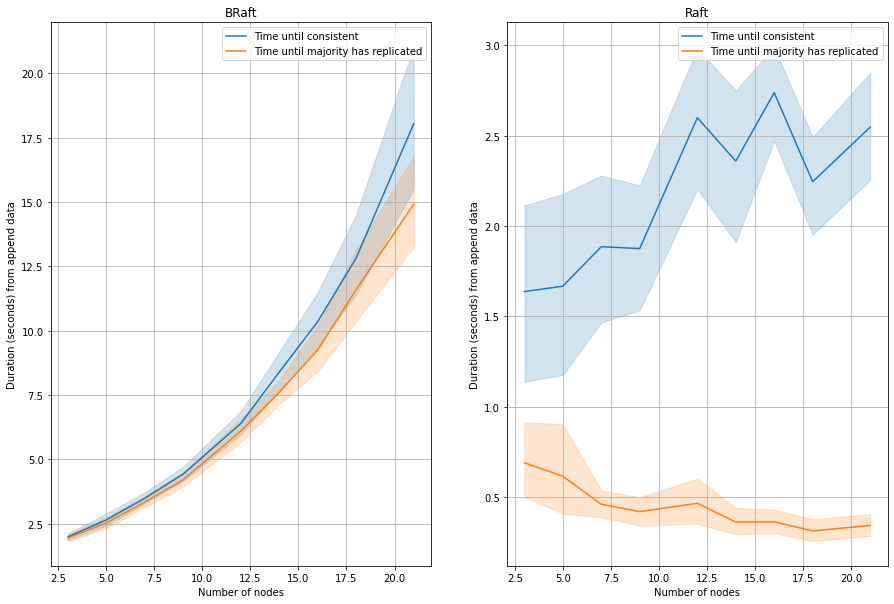

In [63]:
fig, axs = plt.subplots(1, 2, figsize=(15, 10))

# append_df['majority'] =
append_df['rank'] = append_df['nodes'].rank(method='dense') - 1
sns.lineplot(data=append_df[append_df.raftTypeStr == 'BRaft'], x='nodes', y='duration_s',ax=axs[0], label='Time until consistent')
sns.lineplot(data=append_df[append_df.raftTypeStr == 'BRaft'], x='nodes', y='duration_majority_s',ax=axs[0], label='Time until majority has replicated')
axs[0].set_title('BRaft')
sns.lineplot(data=append_df[append_df.raftTypeStr == 'Raft'], x='nodes', y='duration_s',ax=axs[1], label='Time until consistent')
sns.lineplot(data=append_df[append_df.raftTypeStr == 'Raft'], x='nodes', y='duration_majority_s',ax=axs[1], label='Time until majority has replicated')
axs[1].set_title('Raft')

for ax in axs:
    ax.set_xlabel("Number of nodes")
    ax.set_ylabel("Duration (seconds) from append data")
    # ax.legend(title='Algorithm')
    ax.grid()
# fig.savefig('appenddata_time_to_majority.png', dpi=250)

In [19]:
df = pd.read_json('election_results.json.gz', compression='infer')
df['duration_s'] = df.duration_ms / 1000
df.shape

(2520, 11)

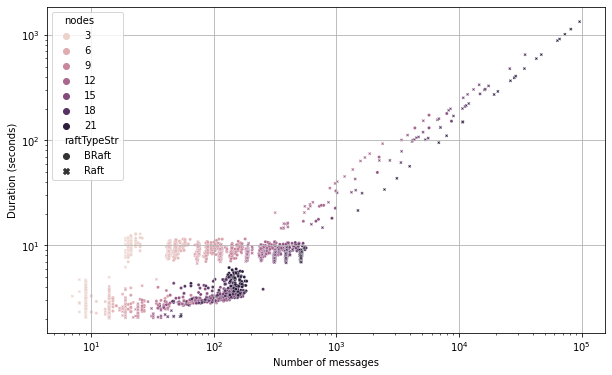

In [215]:
fig, ax = plt.subplots(1,1, figsize=(10,6))
sns.scatterplot(data=df, x='num_messages', y='duration_s', hue='nodes', style='raftTypeStr', s=10)
ax.set_xscale('log')
ax.set_yscale('log')
ax.grid()
# ax.get_legend().remove()
ax.set_xlabel("Number of messages")
ax.set_ylabel("Duration (seconds)")
fig.savefig('scatter.png', dpi=250)

In [23]:
def plot_box(data, ax=None, save=False, fig=None, y='duration_s', logy=True):
    if not ax:
        fig, ax = plt.subplots(1,1,figsize=(20,10))
    sns.boxplot(data=data, x='nodes', y=y, hue='raftTypeStr', ax=ax)
    if logy:
        ax.set_yscale('log')
    ax.grid()
    # ax.set_ylim([0, 30000])

    if fig and save:
        fig.savefig('results_combined_box', dpi=250)
    return fig, ax

In [22]:
# fig, axs = plt.subplots(1,2, sharey=True, figsize=(10,5))
def plot_line(data, ax, y='duration_s', logy=True):
    data['rank'] = data['nodes'].rank(method='dense') - 1
    sns.lineplot(data=data, x='rank', y=y, hue='raftTypeStr',ax=ax)
    if logy:
        ax.set_yscale('log')
    ax.grid()
    return fig, ax

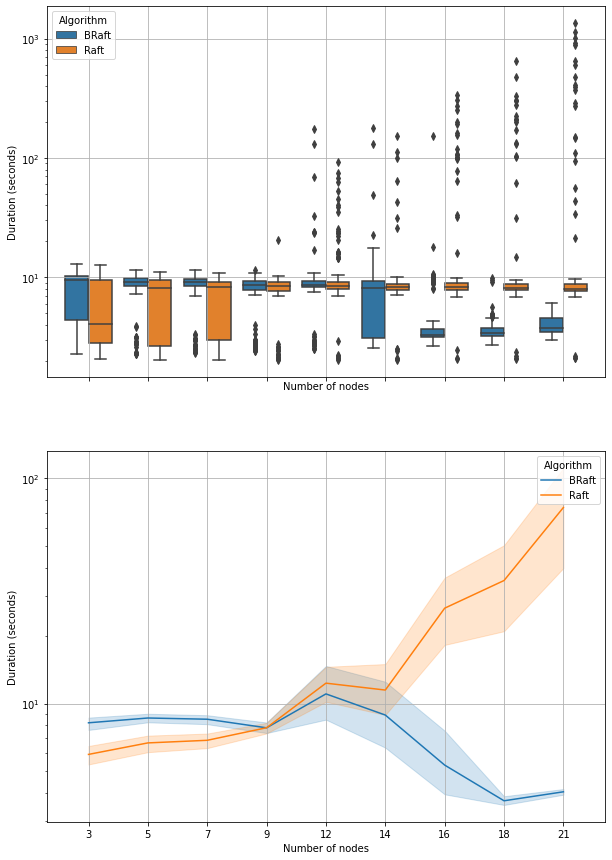

In [20]:
fig, axs = plt.subplots(2, 1, sharex='col', figsize=(10, 15))

plot_box(df, ax=axs[0])
plot_line(df, ax=axs[1])

for ax in axs:
    ax.set_xlabel("Number of nodes")
    ax.set_ylabel("Duration (seconds)")
    ax.legend(title='Algorithm')

fig.savefig('election_duration.png', dpi=250)

In [68]:
df.shape[0] / 9 / 2

140.0

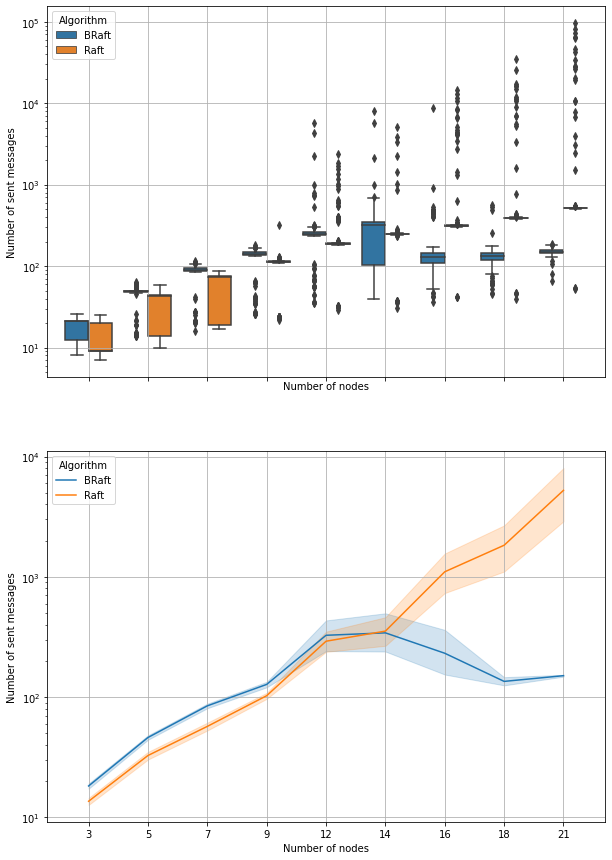

In [228]:
fig, axs = plt.subplots(2, 1, sharex='col', figsize=(10, 15))

plot_box(df, ax=axs[0], y='num_messages')
plot_line(df, ax=axs[1], y='num_messages')

for ax in axs:
    ax.set_xlabel("Number of nodes")
    ax.set_ylabel("Number of sent messages")
    ax.legend(title='Algorithm')

fig.savefig('election_messages.png', dpi=250)

In [ ]:
# fig, axs = plt.subplots(1,2, sharey=True, figsize=(10,5))
def plot_line_v1(data, ax=None, save=False, fig=None):
    if not ax:
        fig, axs = plt.subplots(1,2, sharey=True, figsize=(10,5))
    else:
        axs = ax

    for i, (algo, group) in enumerate(data.groupby('raftTypeStr')):
        ax = axs if type(axs) != np.ndarray else axs[i]
        agged = group.groupby('nodes').duration_ms.agg([np.mean, np.std])
        agged.plot(kind='line', y='mean', ax=ax, label=algo)
        ax.fill_between(agged.index, agged['mean'] - agged['std'], agged['mean'] + agged['std'], alpha = 0.1)

        # ax.set_yscale('log')
        ax.set_xlabel('Number of Nodes')
        ax.set_ylabel('Average time taken in ms')
        ax.grid()
    if fig and save:
        fig.savefig('election_time', dpi=250)
    return fig, ax

In [ ]:
fig, ax = plt.subplots(1,1)
for i, (algo, group) in enumerate(df.groupby('raftTypeStr')):
    group.groupby('nodes').duration_ms.agg([np.mean, np.std]).plot(kind='line', y='mean', yerr='std', ax=ax, label=algo)

ax.set_yscale('log')

In [ ]:
for i in range(3):
    print(i+1)
    c = df[df.file.apply(lambda k: f'election_timer_{i+1}' in k)].groupby(['raftTypeStr', 'nodes', 'run']).count()
    display(c[c==9].dropna())